In [119]:
import uproot
import awkward as ak
import numpy as np

fin = uproot.open("../ZZTo4mu.root")
tree = fin["Events"]

electrons = tree.arrays(filter_name="Electron_*", entry_stop=100_000)
muons = tree.arrays(filter_name="Muon_*", entry_stop=100_000)

# let's build the lepton arrays back into objects 
electrons = ak.zip({k.replace('Electron_', ''): electrons[k] for k in electrons.fields})
muons = ak.zip({k.replace('Muon_', ''): muons[k] for k in muons.fields})

print("Avg. electrons/event:", np.sum(ak.num(electrons)) / tree.num_entries)
print("Avg. muons/event:", np.sum(ak.num(muons)) / tree.num_entries)

Avg. electrons/event: 0.005919026806060315
Avg. muons/event: 0.16856918717279581


In [120]:
import hist
lepton_kinematics = (
    hist.Hist.new
    .StrCat(["electron", "muon"], name="flavor", label="Lepton flavor")
    .Reg(19, 10, 100, name="pt", label="$p_{T}$")
    .Var([-2.5, -1.4, 0, 1.4, 2.5], name="eta", label="$\eta$")
    .Double()
)

# Pass keyword arguments to fill, all arrays must be flat numpy arrays
# User is responsible for ensuring all arrays have same jagged structure!
lepton_kinematics.fill(
    flavor="electron",
    pt=ak.flatten(electrons.pt),
    eta=ak.flatten(electrons.eta),
)
lepton_kinematics.fill(
    flavor="muon",
    pt=ak.flatten(muons.pt),
    eta=ak.flatten(muons.eta),
)

Hist(
  StrCategory(['electron', 'muon'], name='flavor', label='Lepton flavor'),
  Regular(19, 10, 100, name='pt', label='$p_{T}$'),
  Variable([-2.5, -1.4, 0, 1.4, 2.5], name='eta', label='$\\eta$'),
  storage=Double()) # Sum: 167387.0 (261569.0 with flow)

<class 'hist.hist.Hist'>


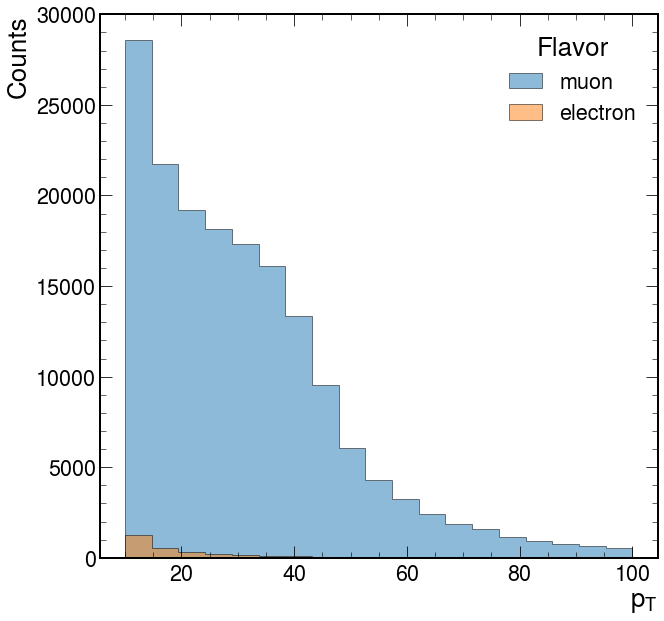

In [121]:
import matplotlib.pyplot as plt
# Now we can start to manipulate this single histogram to plot different views of the data
# here we look at lepton pt for all eta
lepton_pt = lepton_kinematics[:, :, ::sum]
print(type(lepton_pt))

fig, ax = plt.subplots()
lepton_pt.plot1d(
    ax=ax,
    overlay="flavor",
    histtype="fill",
    stack=True,
    alpha=0.5,
    edgecolor=(0, 0, 0, 0.3),
)
# you can edit features of the plot afterwards using matplotlib object-oriented syntax
ax.set_ylabel("Counts")
# e.g. maybe you really miss '90s graphics...
ax.legend(title="Flavor", shadow=True)

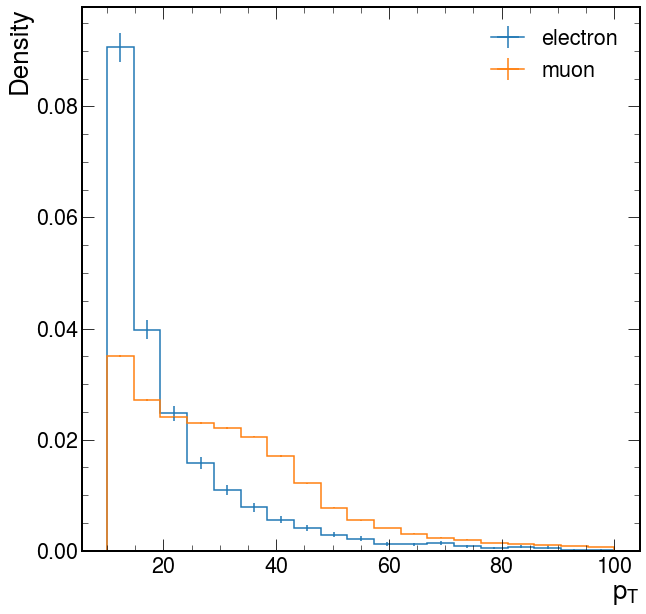

In [122]:
# Clearly the yields are much different, are the shapes similar? We can check by setting `density=True`
lepton_pt.plot1d(overlay="flavor", density=True)
plt.gca().legend()
plt.gca().set_ylabel("Density");

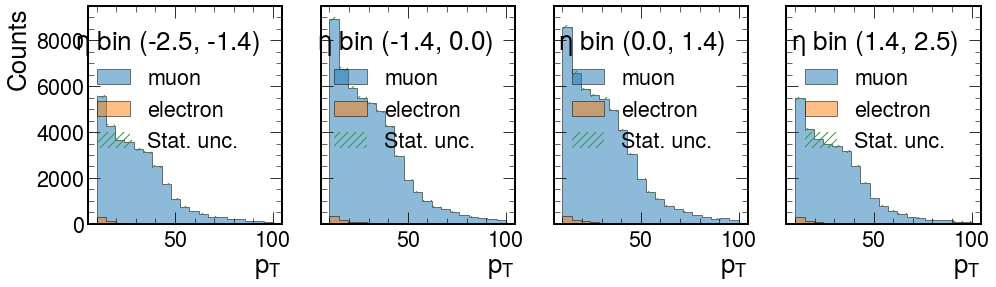

In [123]:
# compare different eta regions
eta_axis = lepton_kinematics.axes[2]
fig, axes = plt.subplots(ncols=len(eta_axis), figsize=(16, 4), sharey=True)
for i, ax in enumerate(axes):
    lepton_kinematics[:, :, i].plot1d(ax=ax, stack=True, histtype="fill", alpha=0.5, edgecolor=(0, 0, 0, 0.3))
    # create a total statistical uncertainty hatch
    tot = lepton_kinematics[::sum, :, i].view()
    ax.stairs(
        edges=lepton_kinematics.axes[1].edges,
        baseline=tot - np.sqrt(tot),
        values=tot + np.sqrt(tot),
        hatch="///",
        label="Stat. unc.",
        facecolor="none",
        linewidth=0,
    )
    ax.legend(title=f"$\eta$ bin {eta_axis[i]}")
    if i == 0:
        ax.set_ylabel("Counts")

In [124]:
# Here we create some pseudodata for the pt histogram so we can make a nice data/mc plot
total = lepton_pt[::sum, :]
data = total.copy()
data.reset()
data.fill(
    np.repeat(total.axes[0].centers, np.random.poisson(total.view()))
)
data
print(total)
print(total.to_numpy())
print(np.sqrt(total))

                     +-------------------------------------------------------+
[ -inf,    10) 90727 |====================================================== |
[   10, 14.74) 28578 |=================                                      |
[14.74, 19.47) 21741 |=============                                          |
[19.47, 24.21) 19176 |===========                                            |
[24.21, 28.95) 18141 |===========                                            |
[28.95, 33.68) 17346 |==========                                             |
[33.68, 38.42) 16129 |==========                                             |
[38.42, 43.16) 13340 |========                                               |
[43.16, 47.89) 9517  |======                                                 |
[47.89, 52.63) 6076  |====                                                   |
[52.63, 57.37) 4286  |===                                                    |
[57.37, 62.11) 3225  |==                            

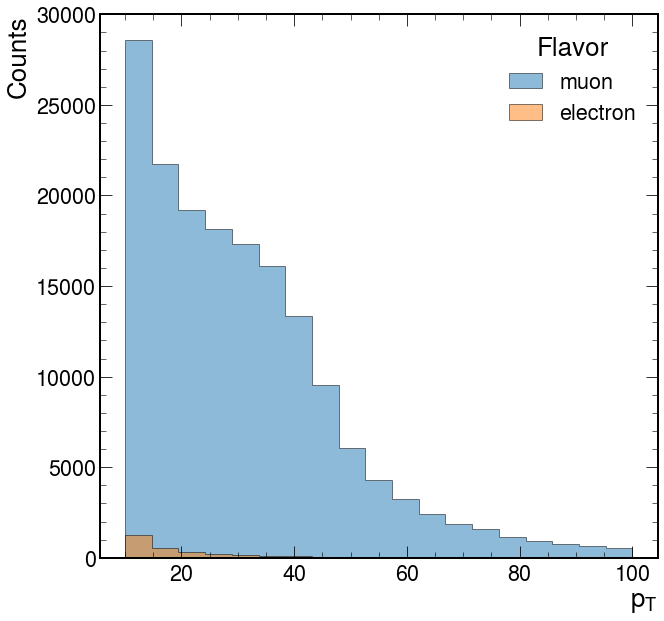

In [125]:
import mplhep
plt.style.use(mplhep.style.CMS)

# Compare this to the style of the plot drawn previously
fig, ax = plt.subplots()
lepton_pt.plot1d(
    ax=ax,
    overlay="flavor",
    histtype="fill",
    stack=True,
    alpha=0.5,
    edgecolor=(0, 0, 0, 0.3),
)
ax.set_ylabel("Counts")
ax.legend(title="Flavor")

[28458. 21580. 19112. 18188. 17232. 16075. 13460.  9627.  6044.  4274.
  3289.  2442.  1828.  1579.  1101.   878.   765.   699.   482.]
[28578. 21741. 19176. 18141. 17346. 16129. 13340.  9517.  6076.  4286.
  3225.  2418.  1852.  1585.  1130.   947.   755.   674.   515.]


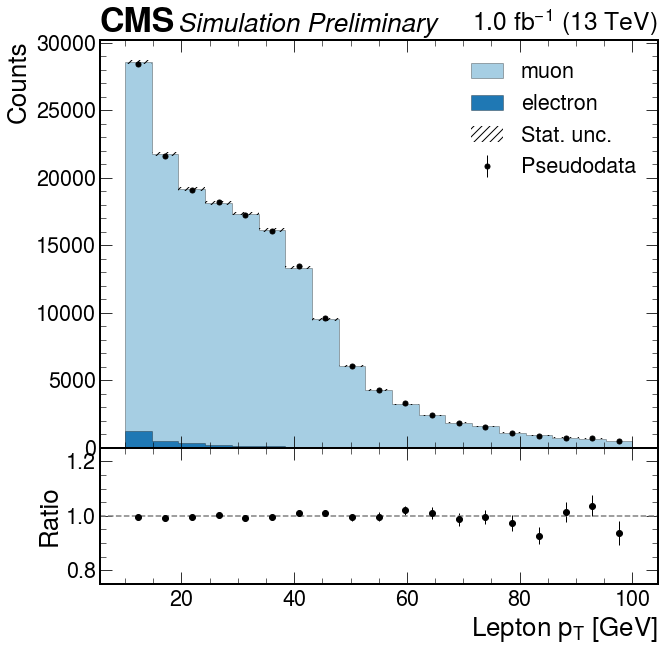

In [128]:
# define a ratio plot figure
fig, (ax, rax) = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[3, 1], hspace=0), sharex=True)

# Here is an example of setting up a color cycler to color the various fill patches
# We get the colors from this useful utility: http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6
from cycler import cycler
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
ax.set_prop_cycle(cycler(color=colors))

# draw components
components = lepton_pt.plot1d(
    ax=ax,
    stack=True,
    histtype="fill",
    edgecolor=(0, 0, 0, 0.3),
)

# create a total statistical uncertainty hatch
ax.stairs(
    edges=lepton_kinematics.axes[1].edges,
    baseline=total - np.sqrt(total),
    values=total + np.sqrt(total),
    hatch="///",
    label="Stat. unc.",
    facecolor="none",
    linewidth=0,
    color="black",
)

data.plot1d(ax=ax, histtype="errorbar", color="k", label="Pseudodata")

ax.set_ylabel("Counts")
ax.legend()

# now draw a ratio plot
from hist.intervals import ratio_uncertainty

rax.errorbar(
    x=data.axes[0].centers,
    y=data.view() / total.view(),
    yerr=ratio_uncertainty(data.view(), total.view(), "poisson"),
    color="k",
    linestyle="none",
    marker="o",
    elinewidth=1,
)
print(data.view())
print(total.view())
rax.axhline(y=1.0, linestyle="dashed", color="gray")
rax.set_ylabel("Ratio", loc="center")
rax.set_ylim(0.75, 1.25)
rax.set_xlabel("Lepton $p_{T}$ [GeV]")

# add some labels
lumi = mplhep.cms.label(ax=ax, lumi=1.0, label="Preliminary")

/tmp/ipykernel_4126350/4213973391.py:108: RuntimeWarning: invalid value encountered in true_divide
  y=data_view/total_bkg_view,
/afs/hep.wisc.edu/home/kaho/miniconda3/envs/coffeaenv_conda/lib/python3.9/site-packages/hist/intervals.py:135: RuntimeWarning: invalid value encountered in true_divide
  ratio = num / denom
/afs/hep.wisc.edu/home/kaho/miniconda3/envs/coffeaenv_conda/lib/python3.9/site-packages/hist/intervals.py:137: RuntimeWarning: invalid value encountered in true_divide
  ratio_uncert = np.abs(poisson_interval(ratio, num / np.square(denom)) - ratio)


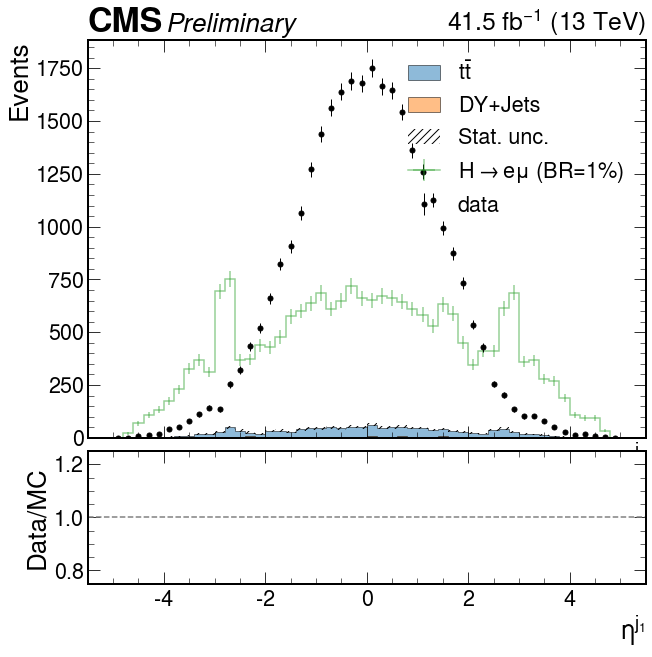

In [17]:
from coffea.util import save, load
from coffea import hist
histo = load("output_btag.coffea")

list_of_bkg = ['TTTo2L2Nu', 'DYJetsToLL_M-50']

xlabel_dict = {
    "$\eta^{j_{1}}$"
}

label_dict = {
    'data': 'data',
    'TTTo2L2Nu': r'$t\bar{t}$',
    'GluGlu_LFV_HToEMu_M125': r'$H\rightarrow e\mu$ (BR=1%)',
    'DYJetsToLL_M-50': r'DY+Jets',
    "Stat. unc.": "Stat. unc."
}

%matplotlib inline

scales = {
    'GluGlu_LFV_HToEMu_M125': 10,
}
histo.scale(scales, axis='dataset')

data = histo[['data'], :].to_hist()
bkg = histo[list_of_bkg, :].to_hist()
signal = histo[['GluGlu_LFV_HToEMu_M125'], :].to_hist()

import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.CMS)

# define a ratio plot figure
fig, (ax, rax) = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[3, 1], hspace=0.05), sharex=True)
#fig, ax = plt.subplots()

# from cycler import cycler
# colors = ['#1f78b4','#33a02c','#e31a1c']
# ax.set_prop_cycle(cycler(color=colors))

bkg.plot1d(
    ax=ax,
    overlay="dataset",
    histtype="fill",
    stack=True,
    alpha=0.5,
    edgecolor=(0, 0, 0, 0.3),
    #label=[r'$t\bar{t}$','data']
)

signal.plot1d(
    ax=ax,
    overlay="dataset",
    #histtype="fill",
    #stack=True,
    alpha=0.5,
    #edgecolor=(0, 0, 0, 0.3),
    #label=r'$H\rightarrow e + \mu$'
)


data.plot1d(ax=ax, histtype="errorbar", color="k")

ax.set_xlabel("$\eta^{j_{1}}$")
ax.set_ylabel("Events")
ax.set_ylim(bottom=0)

import numpy as np

total_bkg = bkg[::sum, :].to_numpy()[0]

# create a total statistical uncertainty hatch
ax.stairs(
    edges=bkg.axes[1].edges,
    baseline=total_bkg - np.sqrt(total_bkg),
    values=total_bkg + np.sqrt(total_bkg),
    hatch="///",
    label="Stat. unc.",
    facecolor="none",
    linewidth=0,
    color="black",
)

legend = ax.legend()

label_list = []
for t in ax.get_legend_handles_labels():
    label_list.append(t)

new_label_list = []
for txt in label_list[1]:
    if txt[0] == '0':
        txt = str(txt)[:4]
    new_label_list.append(label_dict[txt])
label_list[1] = new_label_list

ax.legend(handles=label_list[0], labels=label_list[1])


total_bkg_view = bkg[::sum, :].to_numpy()[0]
data_view = data[::sum, :].to_numpy()[0]
# now draw a ratio plot
from hist.intervals import ratio_uncertainty

rax.errorbar(
    x=data.axes[1].centers,
    y=data_view/total_bkg_view,
    yerr=ratio_uncertainty(data_view, total_bkg_view, "poisson"),
    color="k",
    linestyle="none",
    marker="o",
    elinewidth=1,
)
rax.axhline(y=1.0, linestyle="dashed", color="gray")
rax.set_ylabel("Data/MC", loc="center")
rax.set_ylim(0.75, 1.25)
rax.set_xlabel("$\eta^{j_{1}}$")

# add some labels
lumi = mplhep.cms.label(ax=ax, lumi=41.5, label="Preliminary", data=1)
